In [1]:
import numpy as np
import cv2

import PIL.Image as Image
#import os

import matplotlib.pylab as plt

# import tensorflow as tf
#import tensorflow_hub as tensorflow_hub

from tensorflow import keras
#from tensorflow.keras import layers
#from tensorflow.keras.models import Sequential

import pathlib
import dlib

from sklearn.metrics import euclidean_distances
from tensorflow.keras.optimizers import Adam

In [2]:
IMG_HEIGHT=224 
IMG_WIDTH = 224
batch_size=32

In [3]:
apple_scab_dir = '/kaggle/input/new-plant-diseases-dataset/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)/train/Apple___Apple_scab/'
apple_black_rot_dir = '/kaggle/input/new-plant-diseases-dataset/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)/train/Apple___Black_rot'
apple_rust_dir = '/kaggle/input/new-plant-diseases-dataset/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)/train/Apple___Cedar_apple_rust/'
apple_healthy_dir = '/kaggle/input/new-plant-diseases-dataset/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)/train/Apple___healthy/'

In [4]:
apple_scab_dir = pathlib.Path(apple_scab_dir)
print(apple_scab_dir)
apple_black_rot_dir = pathlib.Path(apple_black_rot_dir)
print(apple_black_rot_dir)
apple_rust_dir = pathlib.Path(apple_rust_dir)
print(apple_rust_dir)
apple_healthy_dir = pathlib.Path(apple_healthy_dir)
print(apple_healthy_dir)

/kaggle/input/new-plant-diseases-dataset/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)/train/Apple___Apple_scab
/kaggle/input/new-plant-diseases-dataset/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)/train/Apple___Black_rot
/kaggle/input/new-plant-diseases-dataset/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)/train/Apple___Cedar_apple_rust
/kaggle/input/new-plant-diseases-dataset/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)/train/Apple___healthy


In [5]:
list(apple_scab_dir.glob('*'))[:5]

[PosixPath('/kaggle/input/new-plant-diseases-dataset/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)/train/Apple___Apple_scab/c4e2b47d-d3c9-418e-9e60-78cead67c5d7___FREC_Scab 2928_new30degFlipLR.JPG'),
 PosixPath('/kaggle/input/new-plant-diseases-dataset/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)/train/Apple___Apple_scab/9555b45b-0080-4d26-8b54-a343b9bf0ffc___FREC_Scab 3313_90deg.JPG'),
 PosixPath('/kaggle/input/new-plant-diseases-dataset/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)/train/Apple___Apple_scab/5a178d63-372d-48c4-adb8-d616130ba3f0___FREC_Scab 3104.JPG'),
 PosixPath('/kaggle/input/new-plant-diseases-dataset/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)/train/Apple___Apple_scab/0a6812de-7416-4ffe-aba9-307599a02c84___FREC_Scab 2973_270deg.JPG'),
 PosixPath('/kaggle/input/new-plant-diseases-dataset/New Plant Diseases Dataset(Augmented)/New Plant Diseases Da

In [6]:
image_count = len(list(apple_scab_dir.glob('*')))
image_count

2016

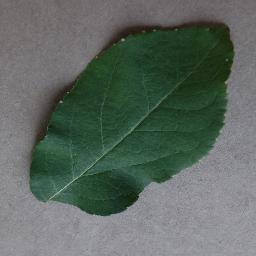

In [7]:
healthy = list(apple_healthy_dir.glob("*"))
Image.open(str(healthy[5]))

In [8]:
image_dict = {
    'scab': list(apple_scab_dir.glob('*')),
    'black_rot' : list(apple_black_rot_dir.glob('*')),
    'rust': list(apple_rust_dir.glob('*')),
    'healthy' : list(apple_healthy_dir.glob('*')),
}

In [9]:
labels_dict = {
    'scab': 0,
    'black_rot' : 1,
    'rust': 2,
    'healthy' : 3,
}

labels_class = ['scab','black_rot','rust','healthy']

In [10]:
X = []
y = []

for label, images in image_dict.items():
  for image in images:
    img = cv2.imread(str(image))
#     gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    resized_img = cv2.resize(img, (IMG_HEIGHT, IMG_WIDTH))

    X.append(resized_img)
    y.append(labels_dict[label])

In [11]:
X = np.array(X)
y = np.array(y)

In [12]:
X.shape
#y.shape

(7771, 224, 224, 3)

In [13]:
X_reshaped = X.reshape(3,-1)
X_reshaped

array([[  0,   0,   0, ..., 107,  58,  44],
       [109,  61,  21, ...,  91,  49, 116],
       [ 80,  47, 112, ..., 125, 127, 145]], dtype=uint8)

In [14]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

In [15]:
import tensorflow_hub as hub
feature_extractor_model = "https://tfhub.dev/google/imagenet/mobilenet_v2_075_224/classification/5"

pretrained_model_without_top_layer = hub.KerasLayer(
    feature_extractor_model, input_shape=(224, 224, 3), trainable=False)

2023-01-27 19:56:51.803511: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-27 19:56:51.834679: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-27 19:56:51.835816: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-27 19:56:51.838993: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

In [16]:
from keras.models import Sequential
from keras.layers import Activation, Dense
model = Sequential([
#  data_augmentation,
  pretrained_model_without_top_layer,
  Dense(4,activation='softmax')
])

In [17]:
model.compile(optimizer = 'adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 1001)              2664345   
_________________________________________________________________
dense (Dense)                (None, 4)                 4008      
Total params: 2,668,353
Trainable params: 4,008
Non-trainable params: 2,664,345
_________________________________________________________________
None


In [18]:
epochs=100

In [19]:
history = model.fit(X_train,y_train,epochs = 100 , validation_data = (X_test, y_test))

2023-01-27 19:56:56.399486: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 877277184 exceeds 10% of free system memory.
2023-01-27 19:56:57.377884: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 877277184 exceeds 10% of free system memory.
2023-01-27 19:56:58.091580: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/100


2023-01-27 19:57:02.007757: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


183/183 [==============================] - 16s 37ms/step - loss: 0.7308 - accuracy: 0.7147 - val_loss: 0.5193 - val_accuracy: 0.8075
Epoch 2/100
183/183 [==============================] - 5s 29ms/step - loss: 0.4572 - accuracy: 0.8308 - val_loss: 0.4151 - val_accuracy: 0.8456
Epoch 3/100
183/183 [==============================] - 7s 36ms/step - loss: 0.4021 - accuracy: 0.8505 - val_loss: 0.3870 - val_accuracy: 0.8564
Epoch 4/100
183/183 [==============================] - 5s 29ms/step - loss: 0.3555 - accuracy: 0.8723 - val_loss: 0.3485 - val_accuracy: 0.8734
Epoch 5/100
183/183 [==============================] - 5s 29ms/step - loss: 0.3388 - accuracy: 0.8708 - val_loss: 0.3412 - val_accuracy: 0.8718
Epoch 6/100
183/183 [==============================] - 5s 29ms/step - loss: 0.3155 - accuracy: 0.8878 - val_loss: 0.3290 - val_accuracy: 0.8744
Epoch 7/100
183/183 [==============================] - 6s 31ms/step - loss: 0.3152 - accuracy: 0.8854 - val_loss: 0.3619 - val_accuracy: 0.8713
Epo

In [20]:
model.save('crop_disease_model.h5')

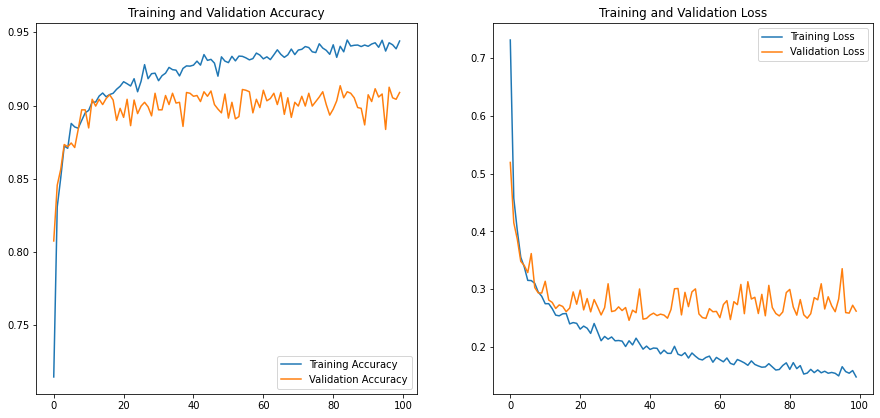

In [21]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(100)

plt.figure(figsize=(15, 15))
plt.subplot(2, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()